# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: This is the list of invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Heracleum sosnowskyi|Orconectes virilis|
|Acridotheres tristis|Herpestes javanicus|Oxyura jamaicensis|
|Ailanthus altissima|Humulus scandens|Pacifastacus leniusculus|
|Alopochen aegyptiaca|Hydrocotyle ranunculoides|Parthenium hysterophorus|
|Alternanthera philoxeroides|Impatiens glandulifera|Pennisetum setaceum|
|Andropogon virginicus|Lagarosiphon major|Perccottus glenii|
|Arthurdendyus triangulatus|Lepomis gibbosus|Persicaria perfoliata|
|Asclepias syriaca|Lespedeza cuneata|Plotosus lineatus|
|Baccharis halimifolia|Lithobates catesbeianus|Procambarus clarkii|
|Cabomba caroliniana|Ludwigia grandiflora|Procambarus fallax|
|Callosciurus erythraeus|Ludwigia peploides|Procyon lotor|
|Cardiospermum grandiflorum|Lygodium japonicum|Prosopis juliflora|
|Cortaderia jubata|Lysichiton americanus|Pseudorasbora parva|
|Corvus splendens|Microstegium vimineum|Pueraria montana|
|Ehrharta calycina|Muntiacus reevesi|Salvinia molesta|
|Eichhornia crassipes|Myocastor coypus|Sciurus carolinensis|
|Elodea nuttallii|Myriophyllum aquaticum|Sciurus niger|
|Eriocheir sinensis|Myriophyllum heterophyllum|Tamias sibiricus|
|Gunnera tinctoria|Nasua nasua|Threskiornis aethiopicus|
|Gymnocoronis spilanthoides|Nyctereutes procyonoides|Trachemys scripta|
|Heracleum mantegazzianum|Ondatra zibethicus|Triadica sebifera|
|Heracleum persicum|Orconectes limosus|Vespa velutina|

In [104]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [105]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot

### Setting up some parameters

In [106]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "interactsWith"
interactionsToExclude = ""

In [107]:

## Define the country of interest
country  = 'BE'

## Define the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used
database = r"..\..\data\cube.db" 

## Define the place to find the interaction data
globiDB = r"..\..\globi\globi.db"

### Define the key taxon for the notebook for which to find all interactions


In [108]:
#taxon = "Oxalis corniculata" #creeping woodsorrel
#taxon = "Oxalis pes-caprae" #Bermuda buttercup
#taxon = "Abramis brama" #common bream
#taxon = "Dikerogammarus villosus" #killer shrimp
#taxon = "Lantanophaga pusillidactyla" #lantana plume moth
#taxon = "Lantana camara" #common lantana
#taxon = "Cirsium vulgare" #spear thistle
#taxon = "Solenopsis invicta" #red imported fire ant
#taxon = "Linepithema humile" #Argentine ant
#taxon = "Procyon lotor" # raccoon
#taxon = "Carpobrotus edulis" #Hottentot-fig
#taxon = "Sciurus carolinensis" # Eastern grey squirrel
#taxon = "Pipistrellus pipistrellus" # Common Pipistrelle
#taxon = "Rousettus aegyptiacus" #Egyptian fruit bat
#taxon = "Ailanthus altissima" #tree of heaven
#taxon = "Triturus carnifex" #Italian crested newt
#taxon = "Xenopus laevis" #African clawed frog
#taxon = "Rhinella marina" #cane toad
#taxon = "Cynops pyrrhogaster" #Japanese Newt
#taxon = "Pachytriton labiatus" #paddle-tail newt
#taxon = "Pleurodeles waltl" #Iberian ribbed newt
#taxon = "Podarcis sicula" #Italian wall lizard

taxon=input()


Impatiens glandulifera


In [109]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [110]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [111]:

print('The taxon to be studied is ' + match['scientificName'])

The taxon to be studied is Impatiens glandulifera Royle


### Just for information take a look at the interactions that the taxon has

In [112]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [113]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
interactDataTaxon = curGlobi.fetchall()

In [114]:
interactDataTaxon

[('interactsWith',)]

In [115]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
interactDataTaxon = curGlobi.fetchall()
interactDataTaxon

[('eats',),
 ('hasHost',),
 ('interactsWith',),
 ('parasiteOf',),
 ('visitsFlowersOf',)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [116]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [117]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [118]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

21

In [119]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [120]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [121]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [122]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

12

In [123]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

12

In [124]:
primaryInteractingTaxa

0     Phytoliriomyza melampyga
2            Pichia fermentans
3       Podosphaera balsaminae
5            Impatiens pallida
6           Impatiens capensis
7          Bombus vosnesenskii
9      Sphaerotheca balsaminae
11              Apis mellifera
12                    Xylocopa
13        Archilochus colubris
15            Bombus impatiens
16      Impatiens glandulifera
dtype: object

## A function to query the globi database

In [125]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [126]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [127]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [128]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [129]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [130]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [131]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [132]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
       'sourceTaxonFamilyName', 'interactionTypeName',
       'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI'
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [133]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [134]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

2031

In [135]:
allInteractingTaxa.head()

0    Phytoliriomyza melampyga
2           Pichia fermentans
3      Podosphaera balsaminae
5           Impatiens pallida
6          Impatiens capensis
dtype: object

In [136]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
interactsWith            10239
visitsFlowersOf           3553
eats                      1502
hasHost                   1342
pollinates                 579
mutualistOf                164
visits                     107
pathogenOf                 103
preysOn                     85
parasiteOf                  68
ectoparasiteOf               9
adjacentTo                   6
endoparasiteOf               5
livesOn                      2
guestOf                      2
ecologicallyRelatedTo        2
coOccursWith                 1
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [137]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [138]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [139]:
taxaFound = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
    

Taxa from GLoBI, but not found in GBIF

Varroa destructor virus-1
Salix rubra
Salix ambigua
Cloudy wing virus
Lake Sinai Virus TO
Lake Sinai Virus SA2
Lake Sinai Virus SA1
Lake Sinai Virus NE
Chronic bee paralysis virus
Bee Macula-like virus
Apis mellifera filamentous virus
Apis flavivirus
Apis dicistrovirus
Virus
Abrus precatorius
Morinda citrifolia
Thymus capitatus


In [140]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [141]:
len(taxaFound)

2031

In [142]:
taxaFound

,0
Phytoliriomyza melampyga,1554086
Pichia fermentans,2599398
Podosphaera balsaminae,5255330
Impatiens pallida,2891767
Impatiens capensis,2891774
Bombus vosnesenskii,1340436
Sphaerotheca balsaminae,2578100
Apis mellifera,1341976
,False
Archilochus colubris,5228514


### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [143]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [144]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [145]:
year

2000

In [146]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Phytoliriomyza melampyga
Pichia fermentans
Podosphaera balsaminae
Impatiens pallida
Impatiens capensis
Impatiens capensis with key 2891774 occurs in 42 km squares.
Bombus vosnesenskii
Sphaerotheca balsaminae
Apis mellifera
Apis mellifera with key 1341976 occurs in 7053 km squares.

Archilochus colubris
Bombus impatiens
Impatiens glandulifera
Impatiens glandulifera with key 2891770 occurs in 3735 km squares.
Impatiens noli-tangere
Impatiens noli-tangere with key 2891779 occurs in 227 km squares.
Impatiens parviflora
Impatiens parviflora with key 2891782 occurs in 1301 km squares.
Closterocerus trifasciatus
Chrysocharis viridis
Chrysocharis crassiscapus
Diglyphus chabrias
Pnigalio soemius
Chrysocharis pentheus
Chrysocharis liriomyzae
Halticoptera circulus
Pnigalio maculipes
Pnigalio minio
Diglyphus pulchripes
Impatiens balsamina
Schizomyia impatientis
Cuscuta gronovii
Rhingia nasica
Catamergus fulvae
Neolasioptera impatientifolia
Collops quadrimaculatus
Reichertella pulicaria
Elachiptera

Trifolium repens
Trifolium repens with key 5358748 occurs in 8349 km squares.
Robinia pseudoacacia
Robinia pseudoacacia with key 5352251 occurs in 4235 km squares.
Crataegus mollis
Cypripedium parviflorum
Andromeda polifolia
Andromeda polifolia with key 5333413 occurs in 158 km squares.
Agalinis tenuifolia
Pycnanthemum pilosum
Pseudognaphalium obtusifolium
Stellaria media
Stellaria media with key 5384604 occurs in 7185 km squares.
Ipomoea pes-caprae
Vernonia fasciculata
Lobelia spicata
Lactuca floridana
Solidago juncea
Solidago missouriensis
Silphium laciniatum
Helenium autumnale
Krigia biflora
Symphyotrichum ericoides
Symphyotrichum laeve
Symphyotrichum drummondii
Symphyotrichum dumosum
Symphyotrichum pilosum
Euthamia graminifolia
Rubus allegheniensis
Ambrosia trifida
Ambrosia trifida with key 3110588 occurs in 14 km squares.
Platanthera blephariglottis
Oldenlandia longifolia
Calopogon tuberosus
Erythronium albidum
Camassia scilloides
Allium tricoccum
Triantha glutinosa
Saccharomyces 

Deformed wing virus
Fennellia flavipes
Cloudy wing virus
Aspergillus niger
Lake Sinai Virus TO
Lake Sinai Virus SA2
Lake Sinai Virus SA1
Lake Sinai Virus NE
Lake Sinai virus 2
Lake Sinai virus 1
Chronic bee paralysis virus
Bee Macula-like virus
Apis mellifera filamentous virus
Apis flavivirus
Apis dicistrovirus
Virus
Slow bee paralysis virus
Spiroplasma melliferum
Spiroplasma apis
Paenibacillus pulvifaciens
Paecilomyces inflatus
Beauveria bassiana
Steinernema scapterisci
Neobuxbaumia polylopha
Tibellus maritimus
Tibellus maritimus with key 2147916 occurs in 20 km squares.
Somatochlora flavomaculata
Pisaura mirabilis
Pisaura mirabilis with key 2150764 occurs in 295 km squares.
Larinioides cornutus
Larinioides cornutus with key 2159204 occurs in 96 km squares.
Emberiza schoeniclus
Emberiza schoeniclus with key 2491557 occurs in 11548 km squares.
Vespula germanica
Vespula germanica with key 1311649 occurs in 955 km squares.
Anolis cristatellus
Phidippus princeps
Phidippus audax
Necrophila

Malacothamnus fasciculatus
Aesculus californica
Fremontodendron californicum
Phacelia californica
Lupinus latifolius
Daphne bholua
Pluchea odorata
Calochortus weedii
Salvia mexicana
Salvia leucantha
Camassia quamash
Cichorium intybus
Cichorium intybus with key 5392252 occurs in 1387 km squares.
Hydrophyllum tenuipes
Physocarpus capitatus
Arbutus menziesii
Lavandula angustifolia
Lavandula angustifolia with key 2927305 occurs in 210 km squares.
Lupinus polyphyllus
Lupinus polyphyllus with key 2964355 occurs in 283 km squares.
Rubus bifrons
Rubus parviflorus
Ceanothus integerrimus
Erigeron foliosus
Arctostaphylos uva-ursi
Trifolium willdenovii
Hypericum perforatum
Hypericum perforatum with key 3189486 occurs in 7167 km squares.
Angelica hendersonii
Rubus ursinus
Sidalcea campestris
Salix hookeriana
Hypericum androsaemum
Hypericum androsaemum with key 3189525 occurs in 121 km squares.
Lathyrus odoratus
Lathyrus odoratus with key 5356514 occurs in 32 km squares.
Epilobium angustifolium
Epil

Ocimum gratissimum
Asphodelus fistulosus
Salvia languidula
Reseda luteola
Reseda luteola with key 3040251 occurs in 1216 km squares.
Symphyotrichum divaricatum
Glandularia lilacina
Fuchsia magellanica
Heliotropium angiospermum
Crataegus monogyna
Crataegus monogyna with key 9220780 occurs in 6631 km squares.
Eucalyptus sideroxylon
Eranthis hyemalis
Eranthis hyemalis with key 3033227 occurs in 78 km squares.
Caesalpinia pulcherrima
Pulsatilla vulgaris
Pulsatilla vulgaris with key 3033621 occurs in 7 km squares.
Orthosiphon aristatus
Arctostaphylos columbiana
Cucumis sativus
Cucumis sativus with key 2874569 occurs in 7 km squares.
Isocoma menziesii
Eucalyptus viminalis
Aspilia silphioides
Koeberlinia spinosa
Porlieria angustifolia
Lomatium dasycarpum
Scilla nana
Buxus microphylla
Scilla bifolia
Lagerstroemia indica
Crocus chrysanthus
Crocus chrysanthus with key 2747489 occurs in 6 km squares.
Anisacanthus quadrifidus
Limnanthes douglasii
Larrea tridentata
Mammillaria dioica
Pimpinella ani

Ficaria verna
Ficaria verna with key 9094061 occurs in 7120 km squares.
Protea neriifolia
Lathraea squamaria
Prunus avium
Prunus avium with key 3020791 occurs in 4391 km squares.
Cirsium texanum
Echinocereus berlandieri
Sophora tomentosa
Asclepias oenotheroides
Ceanothus cuneatus
Citharexylum berlandieri
Ehretia anacua
Conoclinium dissectum
Conoclinium betonicifolium
Phyla lanceolata
Camellia japonica
Stachys drummondii
Erigeron procumbens
Lippia alba
Nemophila maculata
Nemophila maculata with key 2928034 occurs in 7 km squares.
Sarracenia alata
Veronica strictissima
Callisia micrantha
Teucrium cubense
Ebenopsis ebano
Calluna vulgaris
Calluna vulgaris with key 2882482 occurs in 4592 km squares.
Tecoma stans
Leucophyllum frutescens
Buxus sempervirens
Buxus sempervirens with key 2984671 occurs in 43 km squares.
Triteleia laxa
Aloysia gratissima
Elaeis guineensis
Chromolaena odorata
Cordia boissieri
Elymus longifolius
Euphorbia polycarpa
Verbena incompta
Verbena litoralis
Lamium amplexica

Medicago sativa
Medicago sativa with key 9151957 occurs in 2463 km squares.
Ranunculus californicus
Pseudognaphalium californicum
Sabulina californica
Calyptridium monospermum
Arctostaphylos canescens
Arctostaphylos andersonii
Vaccinium ovatum
Lasthenia gracilis
Artemisia californica
Trifolium microdon
Umbellularia californica
Sanicula arctopoides
Viola pedunculata
Madia exigua
Romulea rosea
Epichloe typhina
Sphaeralcea emoryi
Mirabilis melanotricha
Dasiphora fruticosa
Dasiphora fruticosa with key 5370380 occurs in 65 km squares.
Linum lewisii
Verbena macdougalii
Euphorbia esula
Euphorbia esula with key 8203538 occurs in 453 km squares.
Onopordum acanthium
Onopordum acanthium with key 3094900 occurs in 287 km squares.
Citrus sinensis
Pinus ponderosa
Cirsium nuttallii
Hypericum reductum
Euthamia caroliniana ex
Condea verticillata
Liatris tenuifolia
Sideroxylon tenax
Lathyrus pubescens
Senecio bravensis
Eryngium stenophyllum
Gyptis lanigera
Glandularia canadensis
Colletia paradoxa
Campov

Vicia cracca
Vicia cracca with key 2975287 occurs in 5781 km squares.
Iris virginica
Centaurea montana
Centaurea montana with key 9023462 occurs in 37 km squares.
Baptisia alba
Ipomoea quamoclit
Phaseolus coccineus
Malvaviscus arboreus
Ipomoea lobata
Salvia polystachya
Ipomopsis rubra
Thalia geniculata
Oenothera drummondii
Hesperaloe parviflora
Veronica peregrina
Veronica peregrina with key 3172104 occurs in 1001 km squares.
Castilleja tenuiflora
Bouvardia ternifolia
Penstemon roseus
Psittacanthus calyculatus
Ipomoea bracteata
Cyanotis pilosa
Dalea villosa
Solidago sempervirens
Hibiscus syriacus
Hibiscus syriacus with key 3152583 occurs in 89 km squares.
Ranunculus acris
Ranunculus acris with key 3033363 occurs in 9132 km squares.
Solidago rugosa
Lathyrus japonicus
Sonchus arvensis
Sonchus arvensis with key 3105813 occurs in 3331 km squares.
Limonium carolinianum
Althaea officinalis
Althaea officinalis with key 3152520 occurs in 216 km squares.
Acer spicatum
Solanum abbotianum
Vacciniu

In [147]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [148]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 389


In [149]:
taxaFoundInCountry

,count,key,species
0,42,2891774,Impatiens capensis
1,7053,1341976,Apis mellifera
2,3735,2891770,Impatiens glandulifera
3,227,2891779,Impatiens noli-tangere
4,1301,2891782,Impatiens parviflora
5,15,2650903,Onoclea sensibilis
6,56,2165951,Misumena vatia
7,6756,3034742,Daucus carota
8,1606,2971024,Melilotus officinalis
9,4864,5357013,Lotus corniculatus


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [150]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [151]:
# Create graphic object
G = nx.DiGraph()

In [152]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [153]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Rousettus aegyptiacus')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [154]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

11548


### Add the nodes to the graph

In [155]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    dictOfNodeSizes[row['species']] = int(row['count']/maxRecords*100)

### Add edges to the graph

In [156]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Impatiens glandulifera Impatiens capensis interactsWith
C:  Impatiens capensis Impatiens capensis interactsWith
C:  Impatiens capensis Impatiens capensis interactsWith
C:  Impatiens capensis Impatiens capensis interactsWith
C:  Impatiens capensis Impatiens capensis interactsWith
C:  Apis mellifera Impatiens capensis interactsWith
C:  Apis mellifera Impatiens capensis interactsWith
C:  Equisetum hyemale Impatiens capensis interactsWith
C:  Alnus incana Impatiens capensis interactsWith
C:  Equisetum arvense Impatiens capensis interactsWith
C:  Apis mellifera Impatiens capensis interactsWith
C:  Impatiens glandulifera Apis mellifera visitsFlowersOf
C:  Impatiens capensis Apis mellifera interactsWith
C:  Impatiens capensis Apis mellifera interactsWith
C:  Impatiens capensis Apis mellifera interactsWith
C:  Impatiens capensis Apis mellifera visitsFlowersOf
C:  Impatiens capensis Apis mellifera visitsFlowersOf
C:  Apis mellifera Apis mellifera interactsWith
C:  Apis mellifera Apis mellif

C:  Brassica rapa Apis mellifera interactsWith
C:  Brassica rapa Apis mellifera interactsWith
C:  Brassica rapa Apis mellifera interactsWith
C:  Rosa rugosa Apis mellifera interactsWith
C:  Helianthus annuus Apis mellifera interactsWith
C:  Helianthus annuus Apis mellifera interactsWith
C:  Borago officinalis Apis mellifera interactsWith
C:  Borago officinalis Apis mellifera interactsWith
C:  Borago officinalis Apis mellifera interactsWith
C:  Brassica napus Apis mellifera interactsWith
C:  Brassica napus Apis mellifera interactsWith
C:  Brassica napus Apis mellifera interactsWith
C:  Brassica napus Apis mellifera interactsWith
C:  Coriandrum sativum Apis mellifera interactsWith
C:  Coriandrum sativum Apis mellifera interactsWith
C:  Nepeta cataria Apis mellifera interactsWith
C:  Borago officinalis Apis mellifera interactsWith
C:  Borago officinalis Apis mellifera interactsWith
C:  Tropaeolum majus Apis mellifera interactsWith
C:  Buddleja davidii Apis mellifera interactsWith
C:  Tana

C:  Eranthis hyemalis Apis mellifera visitsFlowersOf
C:  Pulsatilla vulgaris Apis mellifera visitsFlowersOf
C:  Melilotus albus Apis mellifera eats
C:  Borago officinalis Apis mellifera eats
C:  Cucumis sativus Apis mellifera interactsWith
C:  Asclepias syriaca Apis mellifera visitsFlowersOf
C:  Asclepias syriaca Apis mellifera visits
C:  Hedera helix Apis mellifera eats
C:  Asclepias syriaca Apis mellifera interactsWith
C:  Eschscholzia californica Apis mellifera eats
C:  Crocus chrysanthus Apis mellifera visitsFlowersOf
C:  Cirsium vulgare Apis mellifera eats
C:  Pimpinella anisum Apis mellifera interactsWith
C:  Ligustrum sinense Apis mellifera interactsWith
C:  Nepeta cataria Apis mellifera interactsWith
C:  Scilla siberica Apis mellifera interactsWith
C:  Scilla siberica Apis mellifera visitsFlowersOf
C:  Asclepias syriaca Apis mellifera visitsFlowersOf
C:  Prunus laurocerasus Apis mellifera visitsFlowersOf
C:  Prunus laurocerasus Apis mellifera interactsWith
C:  Anaphalis margari

C:  Borago officinalis Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Taraxacum officinale Apis mellifera eats
C:  Bidens pilosa Apis mellifera eats
C:  Tropaeolum majus Apis mellifera visitsFlowersOf
C:  Tropaeolum majus Apis mellifera visitsFlowersOf
C:  Pyrus communis Apis mellifera eats
C:  Cosmos bipinnatus Apis mellifera visitsFlowersOf
C:  Allium tuberosum Apis mellifera visitsFlowersOf
C:  Lobelia erinus Apis mellifera eats
C:  Lobelia erinus Apis mellifera visitsFlowersOf
C:  Matricaria chamomilla Apis mellifera visitsFlowersOf
C:  Reynoutria japonica Apis mellifera visitsFlowersOf
C:  Bidens pilosa Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Tropaeolum majus Apis mellifera visitsFlowersOf
C:  Tropaeolum majus Apis mellifera visitsFlowersOf
C:  Tropaeolum majus Apis mellifera visitsFlowersOf
C:  Tropaeolum majus Apis mellifera visitsFlowersOf
C

C:  Cornus sericea Apis mellifera hasHost
C:  Cornus sericea Apis mellifera visitsFlowersOf
C:  Amorpha fruticosa Apis mellifera visitsFlowersOf
C:  Taraxacum officinale Apis mellifera visitsFlowersOf
C:  Plantago lanceolata Apis mellifera visitsFlowersOf
C:  Valeriana officinalis Apis mellifera visitsFlowersOf
C:  Ricinus communis Apis mellifera visitsFlowersOf
C:  Oxalis dillenii Apis mellifera visitsFlowersOf
C:  Crocus tommasinianus Apis mellifera visitsFlowersOf
C:  Achillea millefolium Apis mellifera visitsFlowersOf
C:  Trifolium incarnatum Apis mellifera visitsFlowersOf
C:  Ficaria verna Apis mellifera visitsFlowersOf
C:  Trifolium incarnatum Apis mellifera visitsFlowersOf
C:  Trifolium incarnatum Apis mellifera visitsFlowersOf
C:  Trifolium incarnatum Apis mellifera visitsFlowersOf
C:  Daucus carota Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Trifolium incarnatum Apis mellifera visits

C:  Euphorbia oblongata Apis mellifera visitsFlowersOf
C:  Symphyotrichum novae-angliae Apis mellifera visitsFlowersOf
C:  Eschscholzia californica Apis mellifera visitsFlowersOf
C:  Foeniculum vulgare Apis mellifera visitsFlowersOf
C:  Taraxacum officinale Apis mellifera visitsFlowersOf
C:  Centaurea solstitialis Apis mellifera visitsFlowersOf
C:  Carduus pycnocephalus Apis mellifera visitsFlowersOf
C:  Borago officinalis Apis mellifera visitsFlowersOf
C:  Taraxacum officinale Apis mellifera eats
C:  Taraxacum officinale Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Bellis perennis Apis mellifera visitsFlowersOf
C:  Brassica rapa Apis mellifera visitsFlowersOf
C:  Raphanus sativus Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Foeniculum vulgare Apis mellifera interactsWith
C:  Foeniculum vulgare Apis mellifera visitsFlowersOf
C:  Helianthus annuus Apis 

C:  Crocus vernus Apis mellifera visitsFlowersOf
C:  Fatsia japonica Apis mellifera visitsFlowersOf
C:  Cosmos bipinnatus Apis mellifera visitsFlowersOf
C:  Brassica nigra Apis mellifera visitsFlowersOf
C:  Lamium purpureum Apis mellifera visitsFlowersOf
C:  Erica tetralix Apis mellifera visitsFlowersOf
C:  Hedera helix Apis mellifera visitsFlowersOf
C:  Glechoma hederacea Apis mellifera visitsFlowersOf
C:  Anoda cristata Apis mellifera visitsFlowersOf
C:  Cirsium vulgare Apis mellifera interactsWith
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Taraxacum officinale Apis mellifera eats
C:  Brassica nigra Apis mellifera interactsWith
C:  Trifolium repens Apis mellifera interactsWith
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Tropaeolum majus Apis mellifera visitsFlowersOf
C:  Symphyotrichum novae-angliae Apis mellifera visitsFlowersOf
C:  Trifolium repens Apis mellifera visitsFlowersOf
C:  Cytisus scoparius Apis mellifera interactsWith
C:  Taraxacum officinale Api

C:  Raphanus sativus Apis mellifera visitsFlowersOf
C:  Crocus tommasinianus Apis mellifera visitsFlowersOf
C:  Taraxacum officinale Apis mellifera visitsFlowersOf
C:  Taraxacum officinale Apis mellifera visitsFlowersOf
C:  Marrubium vulgare Apis mellifera eats
C:  Crocus tommasinianus Apis mellifera visitsFlowersOf
C:  Helianthus annuus Apis mellifera visitsFlowersOf
C:  Foeniculum vulgare Apis mellifera visitsFlowersOf
C:  Hypochaeris radicata Apis mellifera visitsFlowersOf
C:  Jacobaea vulgaris Apis mellifera visitsFlowersOf
C:  Crocus tommasinianus Apis mellifera visitsFlowersOf
C:  Tussilago farfara Apis mellifera visitsFlowersOf
C:  Muscari armeniacum Apis mellifera visitsFlowersOf
C:  Cosmos bipinnatus Apis mellifera eats
C:  Crocus tommasinianus Apis mellifera visitsFlowersOf
C:  Foeniculum vulgare Apis mellifera visitsFlowersOf
C:  Cirsium vulgare Apis mellifera visitsFlowersOf
C:  Erodium cicutarium Apis mellifera eats
C:  Erodium cicutarium Apis mellifera interactsWith
C:  A

C:  Sisymbrium orientale Apis mellifera pollinates
C:  Glebionis coronaria Apis mellifera pollinates
C:  Rubus ulmifolius Apis mellifera pollinates
C:  Calluna vulgaris Apis mellifera pollinates
C:  Centaurea nigra Apis mellifera pollinates
C:  Hydrangea macrophylla Apis mellifera pollinates
C:  Rosa rubiginosa Apis mellifera pollinates
C:  Salix fragilis Apis mellifera pollinates
C:  Eschscholzia californica Apis mellifera visitsFlowersOf
C:  Eschscholzia californica Apis mellifera visitsFlowersOf
C:  Eschscholzia californica Apis mellifera visitsFlowersOf
C:  Eschscholzia californica Apis mellifera interactsWith
C:  Datura stramonium Apis mellifera interactsWith
C:  Salix eriocephala Apis mellifera interactsWith
C:  Abutilon theophrasti Apis mellifera interactsWith
C:  Philanthus triangulum Apis mellifera interactsWith
C:  Andromeda polifolia Apis mellifera interactsWith
C:  Sambucus nigra Apis mellifera interactsWith
C:  Ludwigia peploides Apis mellifera interactsWith
C:  Zea mays A

C:  Apis mellifera Pastinaca sativa interactsWith
C:  Apis mellifera Zea mays interactsWith
C:  Apis mellifera Zea mays interactsWith
C:  Apis mellifera Zea mays interactsWith
C:  Apis mellifera Epipactis palustris interactsWith
C:  Apis mellifera Epipactis palustris interactsWith
C:  Apis mellifera Epipactis palustris interactsWith
C:  Apis mellifera Salix eriocephala interactsWith
C:  Apis mellifera Salix eriocephala interactsWith
C:  Apis mellifera Salix eriocephala interactsWith
C:  Apis mellifera Abutilon theophrasti interactsWith
C:  Apis mellifera Abutilon theophrasti interactsWith
C:  Apis mellifera Abutilon theophrasti interactsWith
C:  Apis mellifera Salix fragilis interactsWith
C:  Apis mellifera Salix fragilis interactsWith
C:  Apis mellifera Salix fragilis interactsWith
C:  Apis mellifera Acer negundo interactsWith
C:  Apis mellifera Acer negundo interactsWith
C:  Apis mellifera Acer negundo interactsWith
C:  Apis mellifera Oxalis corniculata interactsWith
C:  Apis mellife

C:  Apis mellifera Oenothera speciosa interactsWith
C:  Apis mellifera Oenothera speciosa interactsWith
C:  Apis mellifera Lamium purpureum interactsWith
C:  Apis mellifera Mentha spicata interactsWith
C:  Apis mellifera Calystegia soldanella interactsWith
C:  Apis mellifera Hedera helix interactsWith
C:  Apis mellifera Brassica nigra interactsWith
C:  Apis mellifera Foeniculum vulgare interactsWith
C:  Apis mellifera Vicia villosa interactsWith
C:  Apis mellifera Heracleum mantegazzianum interactsWith
C:  Apis mellifera Vaccinium corymbosum interactsWith
C:  Apis mellifera Bidens pilosa interactsWith
C:  Apis mellifera Parthenocissus quinquefolia interactsWith
C:  Apis mellifera Tibellus maritimus preysOn
C:  Apis mellifera Pisaura mirabilis preysOn
C:  Apis mellifera Larinioides cornutus preysOn
C:  Apis mellifera Emberiza schoeniclus preysOn
C:  Apis mellifera Vespula germanica preysOn
C:  Apis mellifera Vespula germanica preysOn
C:  Apis mellifera Xysticus ulmi preysOn
C:  Apis mel

In [157]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Impatiens glandulifera Impatiens capensis interactsWith
F:  Impatiens capensis Impatiens capensis interactsWith
F:  Apis mellifera Impatiens capensis interactsWith
F:  Impatiens capensis Impatiens capensis interactsWith
F:  Apis mellifera Impatiens capensis interactsWith
F:  Impatiens parviflora Impatiens capensis interactsWith
F:  Impatiens capensis Impatiens capensis interactsWith
F:  Onoclea sensibilis Impatiens capensis interactsWith
F:  Impatiens capensis Impatiens capensis interactsWith
F:  Apis mellifera Impatiens capensis interactsWith
F:  Apis mellifera Impatiens capensis visitsFlowersOf
F:  Apis mellifera Impatiens capensis visitsFlowersOf
F:  Impatiens capensis Apis mellifera interactsWith
F:  Impatiens capensis Apis mellifera interactsWith
F:  Impatiens capensis Apis mellifera interactsWith
F:  Misumena vatia Apis mellifera eats
F:  Misumena vatia Apis mellifera eats
F:  Misumena vatia Apis mellifera eats
F:  Philanthus triangulum Apis mellifera eats
F:  Synema globosum

F:  Acer negundo Apis mellifera interactsWith
F:  Oxalis corniculata Apis mellifera interactsWith
F:  Symphoricarpos albus Apis mellifera interactsWith
F:  Tanacetum vulgare Apis mellifera interactsWith
F:  Arctium lappa Apis mellifera interactsWith
F:  Leucanthemum vulgare Apis mellifera interactsWith
F:  Bidens frondosa Apis mellifera interactsWith
F:  Datura stramonium Apis mellifera interactsWith
F:  Glechoma hederacea Apis mellifera interactsWith
F:  Sambucus nigra Apis mellifera interactsWith
F:  Sagittaria latifolia Apis mellifera interactsWith
F:  Ludwigia peploides Apis mellifera interactsWith
F:  Trifolium repens Apis mellifera interactsWith
F:  Robinia pseudoacacia Apis mellifera interactsWith
F:  Andromeda polifolia Apis mellifera interactsWith
F:  Stellaria media Apis mellifera interactsWith
F:  Ambrosia trifida Apis mellifera interactsWith
F:  Apis mellifera Apis mellifera interactsWith
F:  Asparagus officinalis Apis mellifera interactsWith
F:  Verbesina alternifolia Apis

F:  Apis mellifera Eschscholzia californica visitsFlowersOf
F:  Apis mellifera Eschscholzia californica visitsFlowersOf
F:  Apis mellifera Eschscholzia californica eats
F:  Apis mellifera Eschscholzia californica eats
F:  Apis mellifera Eschscholzia californica eats
F:  Apis mellifera Eschscholzia californica interactsWith
F:  Apis mellifera Eschscholzia californica interactsWith
F:  Apis mellifera Eschscholzia californica visitsFlowersOf
F:  Apis mellifera Eschscholzia californica visitsFlowersOf
F:  Apis mellifera Eschscholzia californica visitsFlowersOf
F:  Apis mellifera Eschscholzia californica visitsFlowersOf
F:  Apis mellifera Eschscholzia californica interactsWith
F:  Apis mellifera Convolvulus arvensis pollinates
F:  Apis mellifera Raphanus raphanistrum visitsFlowersOf
F:  Apis mellifera Raphanus raphanistrum visitsFlowersOf
F:  Apis mellifera Raphanus raphanistrum visitsFlowersOf
F:  Apis mellifera Raphanus raphanistrum visitsFlowersOf
F:  Apis mellifera Trifolium pratense ea

F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visits
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens interactsWith
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens eats
F:  Apis mellifera Trifolium repens visitsFlowersOf
F:  Apis mellifera Trifolium repens eats
F:  Apis mellifera Trifolium repens interacts

F:  Apis mellifera Cirsium arvense pollinates
F:  Apis mellifera Cirsium arvense interactsWith
F:  Apis mellifera Arctium minus interactsWith
F:  Apis mellifera Arctium minus interactsWith
F:  Apis mellifera Arctium minus visitsFlowersOf
F:  Apis mellifera Arctium minus interactsWith
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Helianthus annuus hasHost
F:  Apis mellifera Helianthus annuus hasHost
F:  Apis mellifera Helianthus annuus hasHost
F:  Apis mellifera Helianthus annuus eats
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Helianthus annuus visitsFlowersOf
F:  Apis mellifera Helianthus annuus interactsWith
F:  Apis mellifera Heliant

F:  Apis mellifera Hedera helix visitsFlowersOf
F:  Apis mellifera Hedera helix visitsFlowersOf
F:  Apis mellifera Hedera helix interactsWith
F:  Apis mellifera Hedera helix visitsFlowersOf
F:  Apis mellifera Hedera helix eats
F:  Apis mellifera Hedera helix visitsFlowersOf
F:  Apis mellifera Hedera helix visitsFlowersOf
F:  Apis mellifera Hedera helix interactsWith
F:  Apis mellifera Hedera helix visitsFlowersOf
F:  Apis mellifera Brassica nigra eats
F:  Apis mellifera Brassica nigra visitsFlowersOf
F:  Apis mellifera Brassica nigra interactsWith
F:  Apis mellifera Foeniculum vulgare interactsWith
F:  Apis mellifera Foeniculum vulgare eats
F:  Apis mellifera Foeniculum vulgare eats
F:  Apis mellifera Foeniculum vulgare eats
F:  Apis mellifera Foeniculum vulgare interactsWith
F:  Apis mellifera Foeniculum vulgare eats
F:  Apis mellifera Foeniculum vulgare eats
F:  Apis mellifera Foeniculum vulgare visitsFlowersOf
F:  Apis mellifera Foeniculum vulgare eats
F:  Apis mellifera Foeniculum 

F:  Apis mellifera Centaurea solstitialis eats
F:  Apis mellifera Centaurea solstitialis eats
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis eats
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis interactsWith
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis interactsWith
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis interactsWith
F:  Apis mellifera Centaurea solstitialis visitsFlowersOf
F:  Apis mellifera Centaurea solstitialis visitsFlowe

F:  Apis mellifera Conium maculatum visitsFlowersOf
F:  Apis mellifera Conium maculatum interactsWith
F:  Apis mellifera Epilobium ciliatum visitsFlowersOf
F:  Apis mellifera Epilobium ciliatum visitsFlowersOf
F:  Apis mellifera Epilobium ciliatum visitsFlowersOf
F:  Apis mellifera Nemophila menziesii visitsFlowersOf
F:  Apis mellifera Trifolium fragiferum visitsFlowersOf
F:  Apis mellifera Trifolium fragiferum visitsFlowersOf
F:  Apis mellifera Silybum marianum interactsWith
F:  Apis mellifera Silybum marianum visitsFlowersOf
F:  Apis mellifera Silybum marianum visitsFlowersOf
F:  Apis mellifera Silybum marianum visitsFlowersOf
F:  Apis mellifera Silybum marianum eats
F:  Apis mellifera Plantago lanceolata visitsFlowersOf
F:  Apis mellifera Plantago lanceolata eats
F:  Apis mellifera Persicaria amphibia pollinates
F:  Apis mellifera Veronica anagallis-aquatica visitsFlowersOf
F:  Apis mellifera Veronica anagallis-aquatica visitsFlowersOf
F:  Apis mellifera Veronica anagallis-aquatica 

F:  Apis mellifera Reseda luteola mutualistOf
F:  Apis mellifera Reseda luteola visitsFlowersOf
F:  Apis mellifera Crataegus monogyna visitsFlowersOf
F:  Apis mellifera Crataegus monogyna visitsFlowersOf
F:  Apis mellifera Crataegus monogyna interactsWith
F:  Apis mellifera Eranthis hyemalis visitsFlowersOf
F:  Apis mellifera Pulsatilla vulgaris visitsFlowersOf
F:  Apis mellifera Pulsatilla vulgaris visitsFlowersOf
F:  Apis mellifera Cucumis sativus interactsWith
F:  Apis mellifera Crocus chrysanthus visitsFlowersOf
F:  Apis mellifera Crocus chrysanthus visitsFlowersOf
F:  Apis mellifera Pimpinella anisum interactsWith
F:  Apis mellifera Pimpinella anisum eats
F:  Apis mellifera Ligustrum sinense interactsWith
F:  Apis mellifera Ligustrum sinense interactsWith
F:  Apis mellifera Ligustrum sinense visitsFlowersOf
F:  Apis mellifera Ocimum basilicum interactsWith
F:  Apis mellifera Ocimum basilicum interactsWith
F:  Apis mellifera Ocimum basilicum visitsFlowersOf
F:  Apis mellifera Ocimu

F:  Apis mellifera Lamium amplexicaule visitsFlowersOf
F:  Apis mellifera Lamium amplexicaule pollinates
F:  Apis mellifera Viburnum tinus visitsFlowersOf
F:  Apis mellifera Tragopogon dubius visitsFlowersOf
F:  Apis mellifera Oenothera elata visitsFlowersOf
F:  Apis mellifera Oenothera elata visitsFlowersOf
F:  Apis mellifera Dipsacus laciniatus visitsFlowersOf
F:  Apis mellifera Dipsacus laciniatus visitsFlowersOf
F:  Apis mellifera Eruca vesicaria visitsFlowersOf
F:  Apis mellifera Eruca vesicaria visitsFlowersOf
F:  Apis mellifera Eruca vesicaria pollinates
F:  Apis mellifera Salvia officinalis visitsFlowersOf
F:  Apis mellifera Papaver somniferum eats
F:  Apis mellifera Papaver somniferum visitsFlowersOf
F:  Apis mellifera Cakile maritima visitsFlowersOf
F:  Apis mellifera Cakile maritima interactsWith
F:  Apis mellifera Rhus typhina visitsFlowersOf
F:  Apis mellifera Vicia faba visitsFlowersOf
F:  Apis mellifera Euphorbia oblongata visitsFlowersOf
F:  Apis mellifera Verbena bonar

In [181]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 327
Number of edges = 400


In [182]:
len(dictOfNodeSizes)

389

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [183]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [184]:
len(G.nodes)

327

## Remove any selfloop edges

In [185]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [186]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

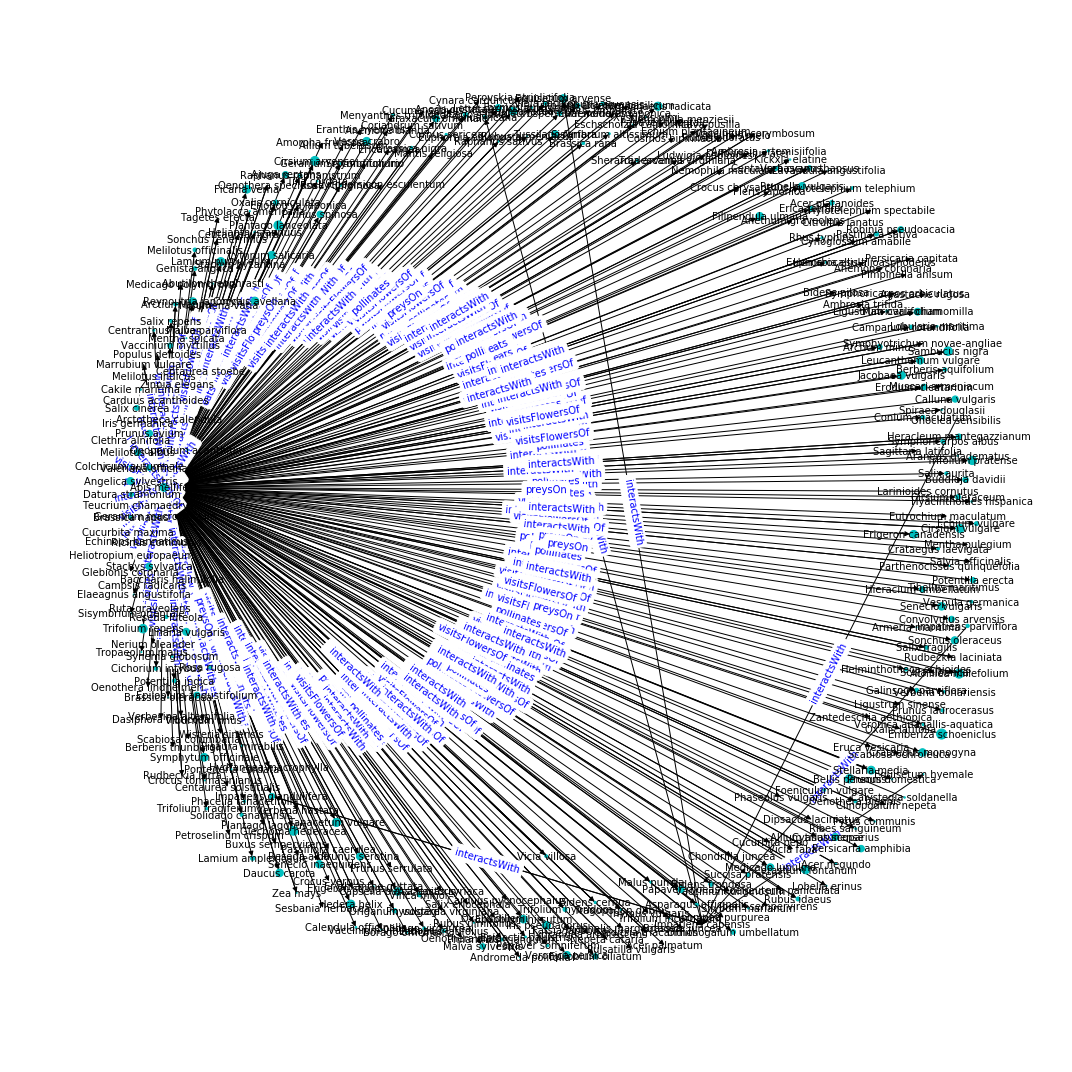

In [187]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [488]:
filename = "..\\docs\\"+taxon+country+".html"
with open(filename, "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='../../../GitHub\cytoscape.js\dist\cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='../../../GitHub\cytoscape.js-cose-bilkent\cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [489]:
with open(filename, "a") as file:
    file.write("<table><th>Species</th><th>Occupancy</th>")
    

In [490]:
species = G.nodes
with open(filename, "a") as file:
    for n in species:
        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")
        #file.write("<a href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a>, "+str(dictOfNodeSizes[n])+"\n")

In [491]:
with open(filename, "a") as file:
    file.write("</table>")    
file.close()

In [492]:
with open(filename, "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [493]:
file = open(filename, "a")
for n in species:
    if n == taxon:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: true,},\n")
    else:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: false,},\n")
file.close()

### Write edges to file

In [494]:
file = open(filename, "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [495]:
with open(filename, "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'darkgreen', \n\
                label: 'data(id)', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '8px', \n\
                'width': 'mapData(occnum, 0, 400, 3, 200)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 200)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '8px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
            },  \n\
            {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'background-color': 'red'  \n\
            }  \n\
        }], \n\
layout:  { \n\
            name: 'cose', padding: 5, animate: true, gravity: 30, animationDuration: 1000 \n\
     } \n\
} \n\
); \n\
")

In [496]:
with open(filename, "a") as file:
    file.write("cy.userZoomingEnabled( true ); \n\
    cy.getElementById('"+taxon+"').select(); \n\
    document.write('Degree of node "+taxon+" ='+cy.getElementById('"+taxon+"').degree()); \n\
    document.write('Degree of node "+taxon+" ='+cy.getElementById('"+taxon+"').degreeCentrality()); </script>; \n\
")

In [276]:
with open(filename, "a") as file:
    file.write("<h2>References</h2><ul>\n")

In [277]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
file = open(filename, "a")
for ref in citations:
    file.write("<li>"+str(ref)+"</li>\n")
file.close()

In [278]:
with open(filename, "a") as file:
    file.write("</ul> \
        </body> \
        </html>")

In [279]:
file.close()

## Output a CSV file for import into Gephi

In [247]:
for node in G.edges:
    print(node[1])

Impatiens glandulifera
Apis mellifera
Equisetum hyemale
Alnus incana
Equisetum arvense
Impatiens glandulifera
Impatiens capensis
Centaurea solstitialis
Veronica anagallis-aquatica
Melilotus indicus
Raphanus sativus
Datura stramonium
Salix eriocephala
Abutilon theophrasti
Philanthus triangulum
Andromeda polifolia
Sambucus nigra
Ludwigia peploides
Zea mays
Epipactis palustris
Sagittaria latifolia
Asparagus officinalis
Verbesina alternifolia
Prunus serotina
Robinia pseudoacacia
Trifolium repens
Trifolium hybridum
Melilotus albus
Dufouriellus ater
Nepeta cataria
Cerastium fontanum
Stellaria media
Malva pusilla
Cucurbita pepo
Populus deltoides
Salix fragilis
Capsella bursa-pastoris
Acer negundo
Oenothera biennis
Oxalis corniculata
Verbena hastata
Marrubium vulgare
Pastinaca sativa
Asclepias syriaca
Campsis radicans
Verbascum thapsus
Solidago canadensis
Symphoricarpos orbiculatus
Symphoricarpos albus
Glechoma hederacea
Leucanthemum vulgare
Bidens cernua
Bidens frondosa
Erigeron strigosus
Tan

### For import into Gephi: A nodes and edges file has been replace by the .dot file format

In [248]:
#with open(taxon+"_nodes.csv", "w") as file:
#    file.write("Id,Label,Category")
#    for node in G.nodes:
#        file.write("'"+edge[0]+edge[1]+"','"+edge[0]+"','"+edge[1]+"','"+nx.get_edge_attributes(G, 'label')[edge]+"'\n")
#file.close()

In [249]:
#with open(taxon+"edges.csv", "w") as file:
#    file.write("Id,Label,Category")
#    for node in G.nodes:
#        file.write("'"+edge[0]+edge[1]+"','"+edge[0]+"','"+edge[1]+"','"+nx.get_edge_attributes(G, 'label')[edge]+"'\n")
#file.close()

In [250]:
#with open(taxon+".csv", "w") as file:
write_dot(G, taxon+".dot")